# Deep Learning - Next Value Prediction
### **Task 1**

| Componente | Matricola |
| --- | --- |
| Gianfranco Sapia | 223954 |
| Andrea De Seta | 227755 |

## **Data Understanding**

In [53]:
import os
import numpy as np

#### **Load dataset**

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
train_path = '/content/drive/MyDrive/Deep Learning Project/Task 1/train.csv' #valid for colab
test_path = '/content/drive/MyDrive/Deep Learning Project/Task 1/test.csv' ##valid for colab

#train_path = 'train.csv'
#test_path = 'test.csv'

In [56]:
import pandas as pd

train_data_loaded = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
train_data_loaded

,x,y,z
0,-24,749,-626
1,-206,930,-63
2,-139,763,-577
3,-503,441,-557
4,-278,705,-396
...,...,...,...
144906,559,-803,-294
144907,559,-803,-294
144908,559,-802,-295
144909,559,-803,-294


##### **Data dimension**

In [57]:
train_data_loaded.size

434733

In [58]:
train_data_loaded.shape

(144911, 3)

##### **Get attribute type and general statistics**

In [59]:
train_data_loaded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144911 entries, 0 to 144910
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   x       144911 non-null  int64
 1   y       144911 non-null  int64
 2   z       144911 non-null  int64
dtypes: int64(3)
memory usage: 3.3 MB


In [60]:
train_data_loaded.describe()

,x,y,z
count,144911.000000,144911.000000,144911.000000
mean,132.732967,-34.800146,-307.588768
std,491.697810,594.977813,538.335654
min,-1239.000000,-1019.000000,-1001.000000
25%,-291.000000,-646.000000,-794.000000
50%,214.000000,-14.000000,-416.000000
75%,539.000000,466.000000,83.000000
max,1039.000000,1078.000000,1032.000000


In [61]:
train_data_loaded = train_data_loaded.astype('float64')
train_data_loaded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144911 entries, 0 to 144910
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       144911 non-null  float64
 1   y       144911 non-null  float64
 2   z       144911 non-null  float64
dtypes: float64(3)
memory usage: 3.3 MB


##### **Data visualization**

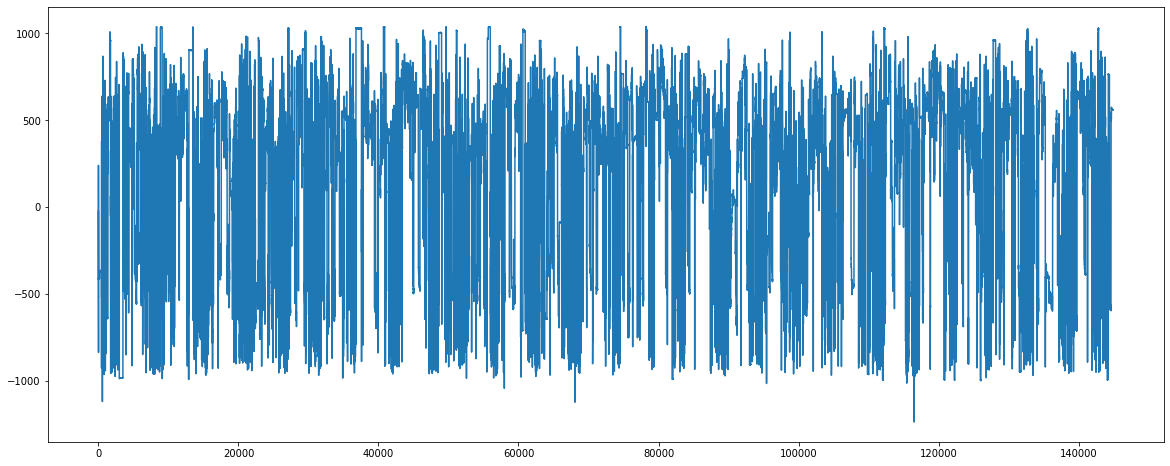

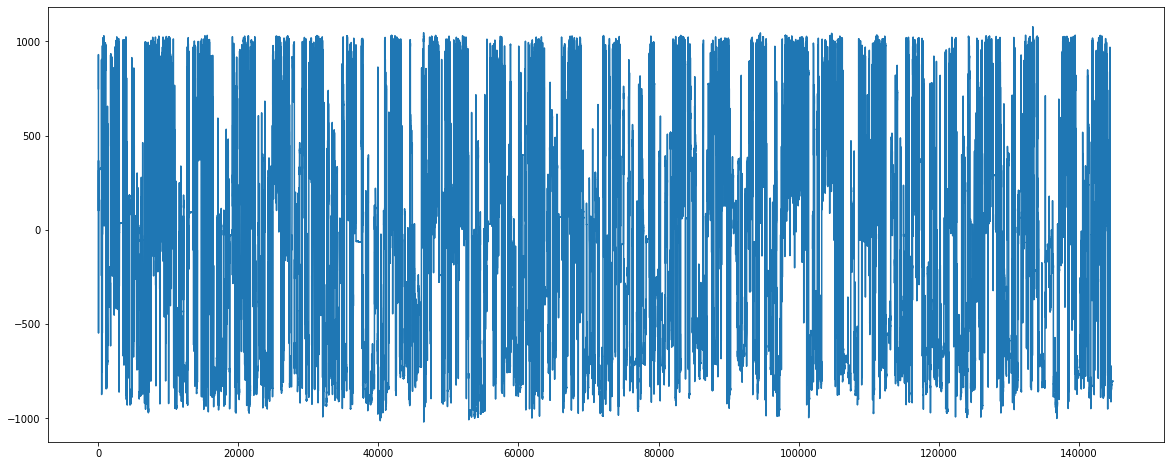

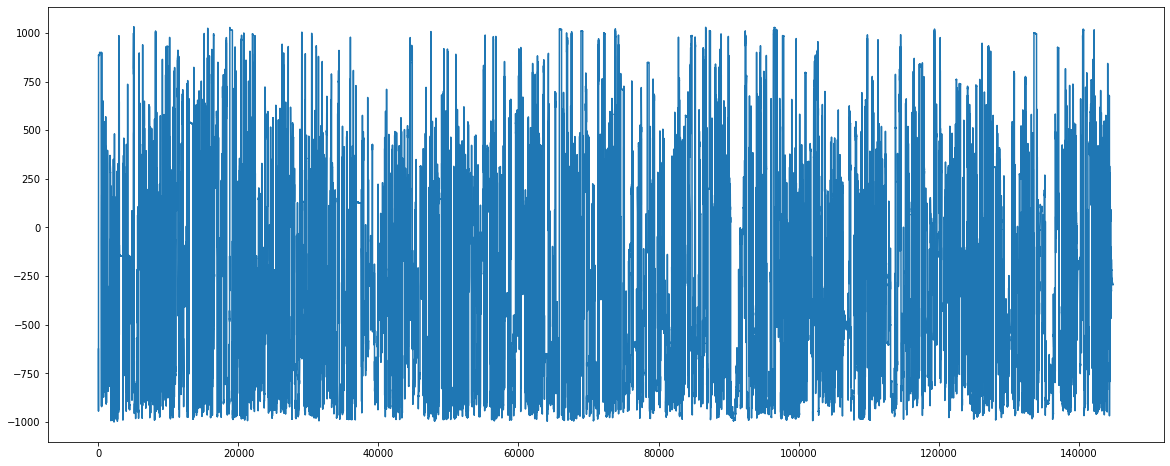

In [62]:
import matplotlib.pyplot as plt

x_column = train_data_loaded['x'] # x
fig = plt.figure(figsize=(20, 8))
plt.plot(x_column)

y_column = train_data_loaded['y'] # y
fig = plt.figure(figsize=(20, 8))
plt.plot(y_column)

z_column = train_data_loaded['z'] # z
fig = plt.figure(figsize=(20, 8))
plt.plot(z_column)

## **Data Preparation**
##### **Trainset normalization**

In [63]:
# normalize the dataset
mean = train_data_loaded.mean()
std = train_data_loaded.std()

train_data_loaded = (train_data_loaded - mean) / std
train_data_loaded

,x,y,z
0,-0.318759,1.317360,-0.591473
1,-0.688905,1.621573,0.454343
2,-0.552642,1.340891,-0.500452
3,-1.292934,0.799694,-0.463301
4,-0.835336,1.243408,-0.164231
...,...,...,...
144906,0.866929,-1.291140,0.025242
144907,0.866929,-1.291140,0.025242
144908,0.866929,-1.289460,0.023385
144909,0.866929,-1.291140,0.025242


##### **Validation data split**

In [64]:
len_split = round(len(train_data_loaded)*0.7)
len_split
print("len_split : " + str(len_split))
train_data = train_data_loaded[:len_split]
val_data = train_data_loaded[len_split:]

len_split : 101438


In [65]:
val_data.index = np.arange(0, len(val_data))
val_data

,x,y,z
0,0.332048,-1.573504,0.305736
1,0.315777,-1.570142,0.287161
2,0.429668,-1.563419,0.424621
3,0.612708,-1.430641,1.000470
4,0.431702,-1.575185,0.688397
...,...,...,...
43468,0.866929,-1.291140,0.025242
43469,0.866929,-1.291140,0.025242
43470,0.866929,-1.289460,0.023385
43471,0.866929,-1.291140,0.025242


In [66]:
train_data

,x,y,z
0,-0.318759,1.317360,-0.591473
1,-0.688905,1.621573,0.454343
2,-0.552642,1.340891,-0.500452
3,-1.292934,0.799694,-0.463301
4,-0.835336,1.243408,-0.164231
...,...,...,...
101433,-0.611622,1.438373,-0.502310
101434,-0.461123,1.483753,-0.442867
101435,0.990989,-0.828938,1.202946
101436,0.722531,-1.420557,1.000470


##### **Data Windowing**

La funzione *data_windowing* prende in input un dataframe (*data*), 
il numero di righe per il quale vogliamo creare una sequenza (*lookback*) 
ed uno shift di spostamento sul dataframe (*step*). 
Tornerà due arrays: uno contenente le sequenze create e l'altro contenente i relativi target delle sequenze

In [67]:
def data_windowing(data, lookback, step):
    
    samples = []
    targets = []

    for i in range(0, len(data) - lookback - 1, step):
        samples.append(data[i: i + lookback])
        targets.append(data[i + lookback])
    
    samples = np.array(samples)
    samples = samples.reshape((samples.shape[0], samples.shape[1], 1))
    
    targets = np.array(targets)
    targets = targets.reshape((targets.shape[0], 1))
    
    return samples, targets

In [68]:
x_train_x, y_train_x = data_windowing(train_data['x'], 30, 6)
x_train_y, y_train_y = data_windowing(train_data['y'], 30, 6)
x_train_z, y_train_z = data_windowing(train_data['z'], 30, 6)

In [69]:
x_val_x, y_val_x = data_windowing(val_data['x'], 30, 6)
x_val_y, y_val_y = data_windowing(val_data['y'], 30, 6)
x_val_z, y_val_z = data_windowing(val_data['z'], 30, 6)

In [70]:
x_test_x, y_test_x = data_windowing(test_data['x'], 30, 6)
x_test_y, y_test_y = data_windowing(test_data['y'], 30, 6)
x_test_z, y_test_z = data_windowing(test_data['z'], 30, 6)

## **Modeling**

In [71]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
import tensorflow as tf
from tensorflow.keras import models, layers

import keras_tuner as kt

my_seed = 44
np.random.seed(my_seed)
tf.random.set_seed(my_seed)
#from tensorflow.keras import layers
#from tensorflow.keras.models import Sequential

##### **Create the models**

Dato l'utilizzo di un hypertuner parameters questa funzione verrà richiamata per ricostruire il tipo di modello sulla base dei valori fissati sulla quale verrà effettuata la ricerca per poter costruire quello che sarà il modello basato sui best hyperparameters. 

In [74]:
def build_model(hp):
    model = models.Sequential()
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 16-256
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=128, step=16)
    model.add(layers.LSTM(hp_units1))
    model.add(layers.Dense(1))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss = 'mae')
    
    return model

In [75]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [76]:
import os
import shutil

if os.path.exists('project_dir') and os.path.isdir('project_dir'):
    shutil.rmtree('project_dir')

In [77]:
tuner_x = kt.Hyperband(build_model,
                     objective='loss',
                     seed=my_seed,
                     max_epochs=15,
                     factor=3,
                     directory='project_dir',
                     project_name='next_value_prediction_x',
                     overwrite=True)

In [78]:
tuner_y = kt.Hyperband(build_model,
                     objective='loss',
                     seed=my_seed,
                     max_epochs=15,
                     factor=3,
                     directory='project_dir',
                     project_name='next_value_prediction_y',
                     overwrite=True)

In [79]:
tuner_z = kt.Hyperband(build_model,
                     objective='loss',
                     seed=my_seed,
                     max_epochs=15,
                     factor=3,
                     directory='project_dir',
                     project_name='next_value_prediction_z',
                     overwrite=True)

In [80]:
tuner_x.search(x_train_x, y_train_x, epochs=10, validation_data=(x_val_x,y_val_x), callbacks=[early_stop])

Trial 30 Complete [00h 00m 43s]
loss: 0.12165659666061401

Best loss So Far: 0.11575865745544434
Total elapsed time: 00h 09m 45s
INFO:tensorflow:Oracle triggered exit


In [81]:
tuner_y.search(x_train_y, y_train_y, epochs=10, validation_data=(x_val_y,y_val_y), callbacks=[early_stop])

Trial 30 Complete [00h 01m 23s]
loss: 0.10291428118944168

Best loss So Far: 0.09217530488967896
Total elapsed time: 00h 13m 03s
INFO:tensorflow:Oracle triggered exit


In [82]:
tuner_z.search(x_train_z, y_train_z, epochs=10, validation_data=(x_val_z,y_val_z), callbacks=[early_stop])

Trial 30 Complete [00h 01m 23s]
loss: 0.11857489496469498

Best loss So Far: 0.11550707370042801
Total elapsed time: 00h 12m 10s
INFO:tensorflow:Oracle triggered exit


In [83]:
# Get the optimal hyperparameters for x
best_hps_x = tuner_x.get_best_hyperparameters(num_trials=1)[0]

#print(f"""
#The hyperparameter search is complete. 
#The optimal number of units in the first densely-connected layer is {best_hps_x.get('units1')}.
#The optimal learning rate for the optimizer is {best_hps_x.get('learning_rate')}.
#""")

best_hps_x.values

{'learning_rate': 0.001,
 'tuner/bracket': 1,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/round': 1,
 'tuner/trial_id': '0022',
 'units1': 96}

In [84]:
# Get the optimal hyperparameters for y
best_hps_y = tuner_y.get_best_hyperparameters(num_trials=1)[0]

#print(f"""
#The hyperparameter search is complete. 
#The optimal number of units in the first densely-connected layer is {best_hps_y.get('units1')}.
#The optimal learning rate for the optimizer is {best_hps_y.get('learning_rate')}.
#""")

best_hps_y.values

{'learning_rate': 0.001,
 'tuner/bracket': 0,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units1': 128}

In [85]:
# Get the optimal hyperparameters for z
best_hps_z = tuner_z.get_best_hyperparameters(num_trials=1)[0]

#print(f"""
#The hyperparameter search is complete. 
#The optimal number of units in the first densely-connected layer is {best_hps_z.get('units1')}.
#The optimal learning rate for the optimizer is {best_hps_z.get('learning_rate')}.
#""")

best_hps_z.values

{'learning_rate': 0.001,
 'tuner/bracket': 0,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units1': 128}

In [86]:
# Build the model for x with the optimal hyperparameters
model_x = tuner_x.hypermodel.build(best_hps_x)
model_x.compile(loss = 'mae', optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps_x.get('learning_rate')))
history_x = model_x.fit(x_train_x, y_train_x, epochs=10, validation_data=(x_val_x,y_val_x))

Epoch 1/10
529/529 [==============================] - 5s 6ms/step - loss: 0.1634 - val_loss: 0.1100
Epoch 2/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1216 - val_loss: 0.1008
Epoch 3/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1176 - val_loss: 0.0983
Epoch 4/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1165 - val_loss: 0.1007
Epoch 5/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1162 - val_loss: 0.0972
Epoch 6/10
529/529 [==============================] - 2s 5ms/step - loss: 0.1166 - val_loss: 0.1004
Epoch 7/10
529/529 [==============================] - 2s 5ms/step - loss: 0.1160 - val_loss: 0.0992
Epoch 8/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1159 - val_loss: 0.0977
Epoch 9/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1163 - val_loss: 0.0970
Epoch 10/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1157 - val_loss: 0.0984

In [87]:
# Build the model for y with the optimal hyperparameters
model_y = tuner_y.hypermodel.build(best_hps_y)
model_y.compile(loss = 'mae', optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps_y.get('learning_rate')))
history_y = model_y.fit(x_train_y, y_train_y, epochs=10, validation_data=(x_val_y,y_val_y))

Epoch 1/10
529/529 [==============================] - 5s 6ms/step - loss: 0.1373 - val_loss: 0.0959
Epoch 2/10
529/529 [==============================] - 3s 6ms/step - loss: 0.0986 - val_loss: 0.0791
Epoch 3/10
529/529 [==============================] - 3s 5ms/step - loss: 0.0937 - val_loss: 0.0798
Epoch 4/10
529/529 [==============================] - 3s 5ms/step - loss: 0.0933 - val_loss: 0.0779
Epoch 5/10
529/529 [==============================] - 3s 5ms/step - loss: 0.0932 - val_loss: 0.0783
Epoch 6/10
529/529 [==============================] - 3s 5ms/step - loss: 0.0929 - val_loss: 0.0796
Epoch 7/10
529/529 [==============================] - 3s 6ms/step - loss: 0.0929 - val_loss: 0.0903
Epoch 8/10
529/529 [==============================] - 3s 5ms/step - loss: 0.0929 - val_loss: 0.0811
Epoch 9/10
529/529 [==============================] - 3s 6ms/step - loss: 0.0933 - val_loss: 0.0779
Epoch 10/10
529/529 [==============================] - 3s 6ms/step - loss: 0.0927 - val_loss: 0.0788

In [88]:
# Build the model for z with the optimal hyperparameters
model_z = tuner_z.hypermodel.build(best_hps_z)
model_z.compile(loss = 'mae', optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps_z.get('learning_rate')))
history_z = model_z.fit(x_train_z, y_train_z, epochs=10, validation_data=(x_val_z,y_val_z))

Epoch 1/10
529/529 [==============================] - 5s 6ms/step - loss: 0.1649 - val_loss: 0.1154
Epoch 2/10
529/529 [==============================] - 3s 6ms/step - loss: 0.1202 - val_loss: 0.0995
Epoch 3/10
529/529 [==============================] - 3s 6ms/step - loss: 0.1176 - val_loss: 0.1064
Epoch 4/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1170 - val_loss: 0.0990
Epoch 5/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1168 - val_loss: 0.1010
Epoch 6/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1168 - val_loss: 0.1038
Epoch 7/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1169 - val_loss: 0.0983
Epoch 8/10
529/529 [==============================] - 3s 6ms/step - loss: 0.1165 - val_loss: 0.0989
Epoch 9/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1166 - val_loss: 0.1001
Epoch 10/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1158 - val_loss: 0.1028

Per ogni modello creato sulla base dei miglior hyperparameters verrà considerato come numero di epoche massime sulla quale effettuare nuovamente il fit il numero di epoche massimo dove si ha la minor "loss"

In [89]:
loss_per_epoch_x = history_x.history['loss']
best_epoch_x = loss_per_epoch_x.index(min(loss_per_epoch_x)) + 1
print('Best epoch: %d' % (best_epoch_x,))

Best epoch: 10


In [90]:
loss_per_epoch_y = history_y.history['loss']
best_epoch_y = loss_per_epoch_y.index(min(loss_per_epoch_y)) + 1
print('Best epoch: %d' % (best_epoch_y,))

Best epoch: 10


In [91]:
loss_per_epoch_z = history_z.history['loss']
best_epoch_z = loss_per_epoch_z.index(min(loss_per_epoch_z)) + 1
print('Best epoch: %d' % (best_epoch_z,))

Best epoch: 10


In [92]:
hypermodel_x = tuner_x.hypermodel.build(best_hps_x)
hypermodel_x.compile(loss = 'mae', optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps_x.get('learning_rate')))
# Retrain the model
history_x = hypermodel_x.fit(x_train_x, y_train_x, epochs=best_epoch_x, validation_data=(x_val_x,y_val_x))

Epoch 1/10
529/529 [==============================] - 4s 6ms/step - loss: 0.1654 - val_loss: 0.1150
Epoch 2/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1219 - val_loss: 0.0998
Epoch 3/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1185 - val_loss: 0.0996
Epoch 4/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1166 - val_loss: 0.1018
Epoch 5/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1166 - val_loss: 0.1006
Epoch 6/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1164 - val_loss: 0.0992
Epoch 7/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1164 - val_loss: 0.0981
Epoch 8/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1159 - val_loss: 0.0986
Epoch 9/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1163 - val_loss: 0.0989
Epoch 10/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1160 - val_loss: 0.0978

In [93]:
hypermodel_y = tuner_y.hypermodel.build(best_hps_y)
hypermodel_y.compile(loss = 'mae', optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps_y.get('learning_rate')))

# Retrain the model
history_y = hypermodel_y.fit(x_train_y, y_train_y, epochs=best_epoch_y, validation_data=(x_val_y,y_val_y))

Epoch 1/10
529/529 [==============================] - 5s 6ms/step - loss: 0.1345 - val_loss: 0.0903
Epoch 2/10
529/529 [==============================] - 3s 6ms/step - loss: 0.0978 - val_loss: 0.0798
Epoch 3/10
529/529 [==============================] - 3s 6ms/step - loss: 0.0942 - val_loss: 0.0807
Epoch 4/10
529/529 [==============================] - 3s 5ms/step - loss: 0.0932 - val_loss: 0.0782
Epoch 5/10
529/529 [==============================] - 3s 6ms/step - loss: 0.0931 - val_loss: 0.0793
Epoch 6/10
529/529 [==============================] - 3s 6ms/step - loss: 0.0929 - val_loss: 0.0806
Epoch 7/10
529/529 [==============================] - 3s 6ms/step - loss: 0.0929 - val_loss: 0.0924
Epoch 8/10
529/529 [==============================] - 3s 6ms/step - loss: 0.0933 - val_loss: 0.0787
Epoch 9/10
529/529 [==============================] - 3s 5ms/step - loss: 0.0927 - val_loss: 0.0778
Epoch 10/10
529/529 [==============================] - 3s 5ms/step - loss: 0.0925 - val_loss: 0.0782

In [94]:
hypermodel_z = tuner_z.hypermodel.build(best_hps_z)
hypermodel_z.compile(loss = 'mae', optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps_z.get('learning_rate')))

# Retrain the model
history_z = hypermodel_z.fit(x_train_z, y_train_z, epochs=best_epoch_z, validation_data=(x_val_z,y_val_z))

Epoch 1/10
529/529 [==============================] - 5s 6ms/step - loss: 0.1673 - val_loss: 0.1094
Epoch 2/10
529/529 [==============================] - 3s 6ms/step - loss: 0.1197 - val_loss: 0.0992
Epoch 3/10
529/529 [==============================] - 4s 7ms/step - loss: 0.1176 - val_loss: 0.1053
Epoch 4/10
529/529 [==============================] - 3s 6ms/step - loss: 0.1177 - val_loss: 0.1001
Epoch 5/10
529/529 [==============================] - 3s 6ms/step - loss: 0.1166 - val_loss: 0.0999
Epoch 6/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1168 - val_loss: 0.1050
Epoch 7/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1162 - val_loss: 0.1011
Epoch 8/10
529/529 [==============================] - 3s 5ms/step - loss: 0.1167 - val_loss: 0.1014
Epoch 9/10
529/529 [==============================] - 3s 6ms/step - loss: 0.1165 - val_loss: 0.0984
Epoch 10/10
529/529 [==============================] - 3s 6ms/step - loss: 0.1162 - val_loss: 0.1013

In [95]:
seq_len_x = x_train_x.shape[1]
num_feat_x = x_train_x.shape[2]

In [96]:
history_x.history

{'loss': [0.16537579894065857,
  0.12193544209003448,
  0.11852554231882095,
  0.11657393723726273,
  0.11663922667503357,
  0.11641491204500198,
  0.11638100445270538,
  0.11591270565986633,
  0.11625978350639343,
  0.1160493716597557],
 'val_loss': [0.11504262685775757,
  0.09979903697967529,
  0.09958292543888092,
  0.10175254940986633,
  0.1006084680557251,
  0.09916439652442932,
  0.09806562960147858,
  0.09859137237071991,
  0.09887727349996567,
  0.09776011854410172]}

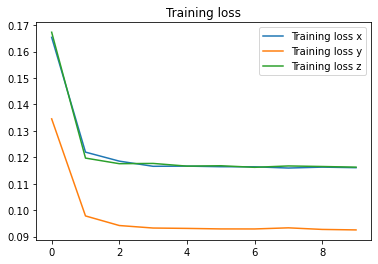

In [97]:
# Plotting results

import matplotlib.pyplot as plt

loss_x = history_x.history['loss'] 
epochs_x = range(len(loss_x))
loss_y = history_y.history['loss'] 
epochs_y = range(len(loss_y))
loss_z = history_z.history['loss'] 
epochs_z = range(len(loss_z)) 

plt.plot(epochs_x, loss_x,  label='Training loss x')
plt.plot(epochs_y, loss_y,  label='Training loss y')
plt.plot(epochs_z, loss_z,  label='Training loss z')
plt.title('Training loss')
plt.legend()
plt.show()

## *Prediction*

Predizione basata sul modello costruito con i miglior hyperparameters e trainato sul numero di epoche ottimali considerate sopra. La predizione è effettuata sulle sequenze di test set normalizzate

In [98]:
prediction_x = hypermodel_x.predict((x_test_x - mean['x']) / std['x'])
prediction_x = (prediction_x * std['x']) + mean['x']

In [99]:
prediction_y = hypermodel_y.predict((x_test_y - mean['y']) / std['y'])
prediction_y = (prediction_y * std['y']) + mean['y']

In [100]:
prediction_z = hypermodel_z.predict((x_test_z - mean['z']) / std['z'])
prediction_z = (prediction_z * std['z']) + mean['z']

#### *Metrics*

Risultati ottenuti dalla predizione su ogni feature del dataset

In [101]:
#  x = 81.06; y = 85.26; z = 79.94
from sklearn.metrics import mean_absolute_error

mae_x = mean_absolute_error(y_test_x, prediction_x)
print('MAE X: ' + str(mae_x))

mae_y = mean_absolute_error(y_test_y, prediction_y)
print('MAE Y: ' + str(mae_y))

mae_z = mean_absolute_error(y_test_z, prediction_z)
print('MAE Z: ' + str(mae_z))

MAE X: 73.58875112590657
MAE Y: 80.48110151229177
MAE Z: 74.20807178783062


In [102]:
x_rate = mae_x/81.06
y_rate = mae_y/85.26
z_rate = mae_z/79.96

print("x_rate: %f",x_rate)
print("y_rate: %f",y_rate)
print("z_rate: %f",z_rate)

x_rate: %f 0.9078306331841423
y_rate: %f 0.9439491146175436
z_rate: %f 0.9280649298127892


### **Task 1.2**
## *Evaluation* 

Evaluation basata sulla feature *Y*. Per ogni combinazione verranno affrontate le seguenti fasi: search sui best hyperparameters, ricostruzione del modello basato sui best hyperparameters, prediction e calcolo del mae

In [103]:
configuration = []
forecast_y = []

for lookback in [12,30,60]:
    for step in [3,6,9]:

        print("Trying " + str(lookback) + " every " + str(step) + " steps")

        x_train_y, y_train_y = data_windowing(train_data['y'], lookback, step)
        x_val_y, y_val_y = data_windowing(val_data['y'], lookback, step)
        x_test_y, y_test_y = data_windowing(test_data['y'], lookback, step)

        tuner_y = kt.Hyperband(build_model,
                         objective='loss',
                         seed=my_seed,
                         max_epochs=15,
                         factor=3,
                         overwrite=True,
                         directory='task_1_2',
                         project_name='seq_'+str(lookback)+'_step_'+str(step))

        tuner_y.search(x_train_y, y_train_y, epochs=10, validation_data=(x_val_y,y_val_y), callbacks=[early_stop])

        best_hps_y = tuner_y.get_best_hyperparameters(num_trials=1)[0]

        model_y = tuner_y.hypermodel.build(best_hps_y)
        model_y.compile(loss = 'mae', optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps_y.get('learning_rate')))
        history_y = model_y.fit(x_train_y, y_train_y, epochs=10, validation_data=(x_val_y,y_val_y))

        loss_per_epoch_y = history_y.history['loss']
        best_epoch_y = loss_per_epoch_y.index(min(loss_per_epoch_y)) + 1

        hypermodel_y = tuner_y.hypermodel.build(best_hps_y)
        hypermodel_y.compile(loss = 'mae', optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps_y.get('learning_rate')))
        hypermodel_y.fit(x_train_y, y_train_y, epochs=best_epoch_y, validation_data=(x_val_y,y_val_y))

        prediction_y = hypermodel_y.predict((x_test_y - mean['y']) / std['y'])
        prediction_y = (prediction_y * std['y']) + mean['y']

        mae_y = mean_absolute_error(y_test_y, prediction_y)
        print('MAE Y: ' + str(mae_y))

        configuration.append(str(lookback) + "-" + str(step))
        forecast_y.append(mae_y)

Trial 30 Complete [00h 00m 35s]
loss: 0.11006272584199905

Best loss So Far: 0.09169765561819077
Total elapsed time: 00h 08m 52s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
353/353 [==============================] - 5s 9ms/step - loss: 0.1531 - val_loss: 0.1214
Epoch 2/10
353/353 [==============================] - 3s 7ms/step - loss: 0.1052 - val_loss: 0.1089
Epoch 3/10
353/353 [==============================] - 2s 7ms/step - loss: 0.0969 - val_loss: 0.0858
Epoch 4/10
353/353 [==============================] - 3s 7ms/step - loss: 0.0942 - val_loss: 0.0809
Epoch 5/10
353/353 [==============================] - 3s 7ms/step - loss: 0.0948 - val_loss: 0.0788
Epoch 6/10
353/353 [==============================] - 2s 7ms/step - loss: 0.0928 - val_loss: 0.0783
Epoch 7/10
353/353 [==============================] - 2s 7ms/step - loss: 0.0925 - val_loss: 0.0811
Epoch 8/10
353/353 [==============================] - 3s 9ms/step - loss: 0.0926 - val_loss: 0.0822
Epoch 9/10
353/353 [=============

In [104]:
min_mae = min(forecast_y)
min_mae

80.29701115879003

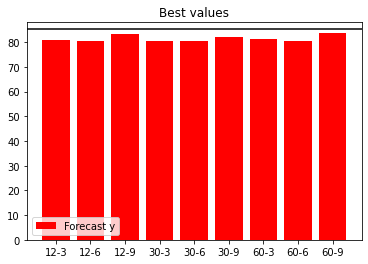

In [105]:
# Plotting results

import matplotlib.pyplot as plt

plt.bar(configuration, forecast_y, label='Forecast y', color='red')
plt.axhline(85.26, color='black')
plt.axhline(86.26, color='white')
plt.title('Best values')
plt.legend()
plt.show()